In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from itertools import combinations
import numpy as np
SEED = 25


In [13]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df['class'] = round(df['class'] / 10).astype(int)
df = df[df['class'] != 1]
_type = df['type'].to_list()
df = df.drop(['name', 'side_mistake',
              'vs', 'squared_vs', 'ttr', 'root_ttr',
              'log_ttr', 'uber_ttr', 'd', 'vvi',
              'squared_vv', 'punct_mistakes_pp',
              'punct_mistakes_because',
              'punct_mistakes_but', 'punct_mistakes_compare'], axis=1)

df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,6,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",6,1,0


In [14]:
df.shape

(3440, 62)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440 entries, 0 to 3440
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   av_depth               3440 non-null   float64
 1   max_depth              3440 non-null   int64  
 2   min_depth              3440 non-null   int64  
 3   num_acl                3440 non-null   int64  
 4   num_rel_cl             3440 non-null   int64  
 5   num_advcl              3440 non-null   int64  
 6   num_sent               3440 non-null   int64  
 7   num_tok                3440 non-null   int64  
 8   av_tok_before_root     3440 non-null   float64
 9   av_len_sent            3440 non-null   float64
 10  num_cl                 3440 non-null   int64  
 11  num_tu                 3440 non-null   int64  
 12  num_compl_tu           3440 non-null   int64  
 13  num_coord              3440 non-null   int64  
 14  num_poss               3440 non-null   int64  
 15  num_

In [16]:
df['class'].value_counts()

6    2680
7     308
5     215
4     122
8      77
2      24
3      14
Name: class, dtype: int64

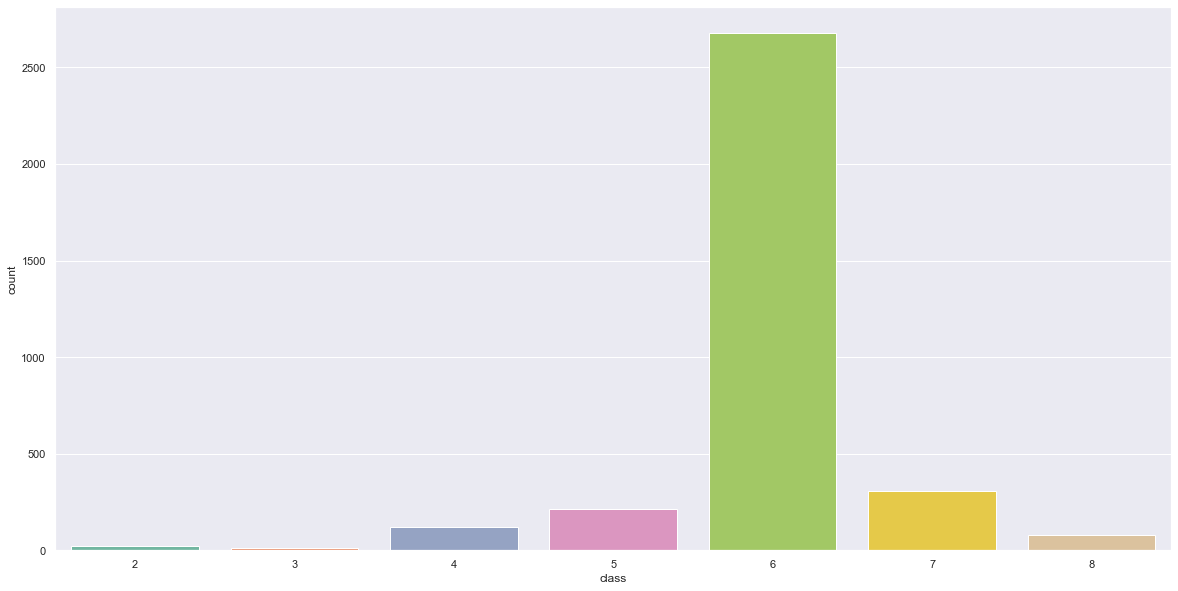

In [17]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")

In [7]:
from umap import UMAP

In [18]:
feature_columns = [col for col in df.columns if col not in ['class', 'name', 'text', 'type']]
X = df[feature_columns]
y = df['class'] - 2
y.loc[y == 1] = 3
y.loc[y == 0] = 3
y.loc[y == 2] = 3
y.loc[y == 5] = 6

y.loc[y == 3] = 0
y.loc[y == 4] = 1
y.loc[y == 6] = 2

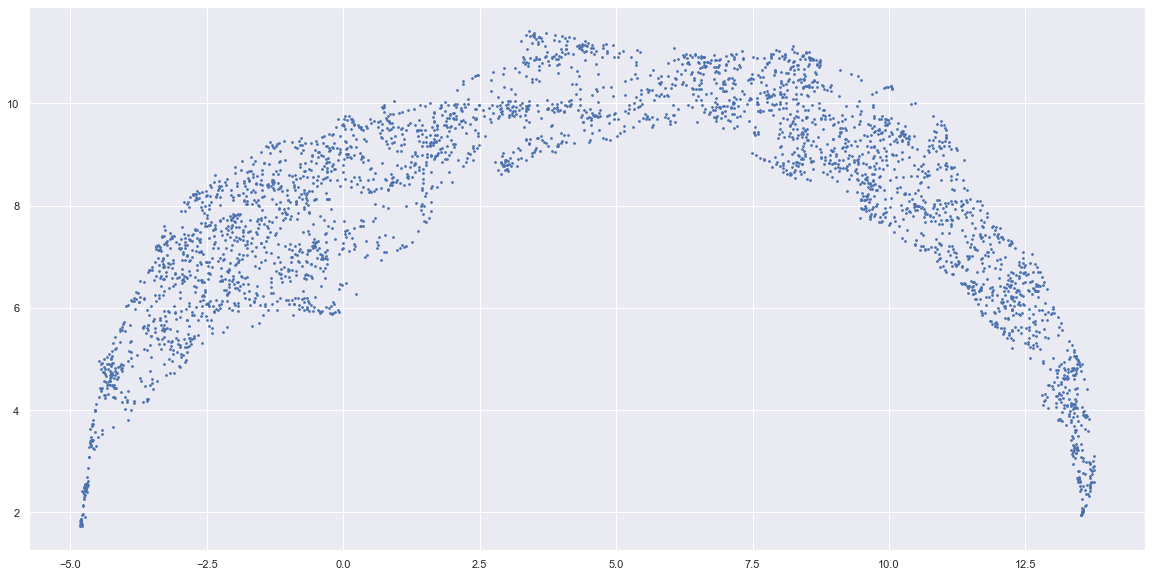

In [9]:
umap = UMAP()
umaped_vct=umap.fit_transform(X)
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

In [10]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

Так как количество элементов в классах не равномерно то объединим классы 2,3,4,5; 7, 8; и уберем часть элементов из 6 класса

In [11]:

train_y.value_counts()

1    2139
2     322
0     291
Name: class, dtype: int64

In [12]:
dummy = train_y.loc[train_y == 1][:315]
train_y.drop(train_y.loc[train_y == 1].index, inplace=True)
train_y = pd.concat([train_y, dummy], ignore_index=True)
train_y.value_counts()

2    322
1    315
0    291
Name: class, dtype: int64

In [13]:
y_idx = train_y.index
train_x = train_x.iloc[y_idx.to_list()]
train_x.reset_index(inplace=True, drop=True)
test_x.reset_index(inplace=True, drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)

In [14]:
train_y2 = []
for y in train_y:
    y2 = np.zeros(3)
    y2[y] = 1
    train_y2.append(y2)
    
test_y2 = []
for y in test_y:
    y2 = np.zeros(3)
    y2[y] = 1
    test_y2.append(y2)
    
train_y2 = np.array(train_y2)
test_y2 = np.array(test_y2)

In [24]:
def create_model(neurons1=None, neurons2=None, neurons3=None, activation="relu", optimizer='Adam', loss=keras.losses.MeanSquaredError()):
    model = keras.Sequential()
    if neurons1:
        model.add(Dense(neurons1, activation=activation, kernel_regularizer=keras.regularizers.l2(0.001)))
    if neurons2:
        model.add(Dense(neurons2, activation=activation, kernel_regularizer=keras.regularizers.l2(0.001)))
    if neurons3:
        model.add(Dense(neurons3, activation=activation, kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(3, activation="softmax"))
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics=[keras.metrics.categorical_accuracy]
         )
    return model

In [25]:
model = KerasClassifier(build_fn=create_model)

In [15]:
from sklearn.metrics import make_scorer, accuracy_score
def custom_scorer(y_true, y_pred):
    y_true = [np.argmax(y) for y in y_true]
    y_true = np.array(y_true)
    return accuracy_score(y_true, y_pred)
scorer = make_scorer(custom_scorer, greater_is_better=True)

In [16]:
neurons1 = [2**i for i in range(4, 9)]
neurons2 = [2**i for i in range(4, 9)]
neurons3 = [2**i for i in range(4, 9)]
activation = ["relu", "tanh"]
optimizer = ['Adam', 'SGD']
loss = ['mse']
epochs = [20, 50, 100]
batch_size= [5, 10, 15, 20]

param_grid = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3, 
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  epochs=epochs,
                  batch_size=batch_size)
param_grid

{'neurons1': [16, 32, 64, 128, 256],
 'neurons2': [16, 32, 64, 128, 256],
 'neurons3': [16, 32, 64, 128, 256],
 'activation': ['relu', 'tanh'],
 'optimizer': ['Adam', 'SGD'],
 'loss': ['mse'],
 'epochs': [20, 50, 100],
 'batch_size': [5, 10, 15, 20]}

In [17]:
%%time
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, n_jobs=-1, verbose=1, cv=3)
grid_result = grid.fit(train_x, train_y2)

Fitting 3 folds for each of 6000 candidates, totalling 18000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 89.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 97.7min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 117.0min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 138.6min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 152.8min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 174.1min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 189.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 214.3min
[Parallel(n_jobs=-1)]: Done 11226 tasks

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

93/93 [==============================] - 0s 2ms/step - loss: 0.5450 - categorical_accuracy: 0.3362
Epoch 2/50
93/93 [==============================] - 0s 718us/step - loss: 0.5444 - categorical_accuracy: 0.3394
Epoch 3/50
93/93 [==============================] - 0s 463us/step - loss: 0.5441 - categorical_accuracy: 0.3394
Epoch 4/50
93/93 [==============================] - 0s 358us/step - loss: 0.5437 - categorical_accuracy: 0.3394
Epoch 5/50
93/93 [==============================] - 0s 548us/s

In [18]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.618708 using {'activation': 'relu', 'batch_size': 10, 'epochs': 50, 'loss': 'mse', 'neurons1': 32, 'neurons2': 32, 'neurons3': 32, 'optimizer': 'SGD'}


In [19]:
pred_y = grid_result.best_estimator_.predict(test_x)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [20]:
confusion_matrix(test_y, pred_y)

array([[ 20,  36,  28],
       [ 54, 283, 204],
       [  7,  35,  21]], dtype=int64)

In [21]:
accuracy_score(test_y, pred_y)

0.47093023255813954

Теперь сверточные сети.

In [16]:
train_x2 = np.array(train_x)
test_x2 = np.array(test_x)

In [17]:
train_x3 = train_x2.reshape(-1, 59, 1)
test_x3 = test_x2.reshape(-1, 59, 1)

In [18]:
def create_model_conv(neurons1=None, neurons2=None, neurons3=None, core=3, activation="relu", optimizer='Adam', loss=keras.losses.MeanSquaredError()):
    model = keras.Sequential()
    if neurons1:
        model.add(layers.Conv1D(neurons1, core, activation=activation))
    if neurons2:
        model.add(layers.Conv1D(neurons2, core, activation=activation))
    if neurons3:
        model.add(layers.Conv1D(neurons3, core, activation=activation))
    model.add(layers.Flatten())
    model.add(Dense(3, activation="softmax"))
    model.compile(optimizer=optimizer, 
                  loss=loss,
                  metrics=[keras.metrics.categorical_accuracy]
         )
    return model

In [19]:
neurons1 = [2**i for i in range(3, 7)]
neurons2 = [2**i for i in range(3, 7)]
neurons3 = [2**i for i in range(3, 7)]
core = [3, 4, 5, 10]
activation = ["relu", "tanh"]
optimizer = ['Adam', 'SGD']
loss = ['mse']
epochs = [100,]
batch_size= [5, 10, 15, 20]

param_grid_conv = dict(neurons1=neurons1, 
                  neurons2=neurons2, 
                  neurons3=neurons3,
                  core=core,
                  activation=activation, 
                  optimizer=optimizer,
                  loss=loss,
                  epochs=epochs,
                  batch_size=batch_size)
param_grid_conv

{'neurons1': [8, 16, 32, 64],
 'neurons2': [8, 16, 32, 64],
 'neurons3': [8, 16, 32, 64],
 'core': [3, 4, 5, 10],
 'activation': ['relu', 'tanh'],
 'optimizer': ['Adam', 'SGD'],
 'loss': ['mse'],
 'epochs': [100],
 'batch_size': [5, 10, 15, 20]}

In [20]:
model_conv = KerasClassifier(build_fn=create_model_conv)

In [21]:
%%time
early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=5)
grid_conv = GridSearchCV(estimator=model_conv, param_grid=param_grid_conv, scoring=scorer, verbose=1, cv=3, n_jobs=-1)
grid_result_conv = grid_conv.fit(train_x3, train_y2)

Fitting 3 folds for each of 4096 candidates, totalling 12288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 109.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 179.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 258.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 326.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 423.1min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 498.4min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 603.4min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 706.3min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 874.3min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 1044.4min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 1218.0min
[Parallel(n_jobs=-1)]: Done 1122

Epoch 1/100
186/186 [==============================] - 7s 37ms/step - loss: 0.4397 - categorical_accuracy: 0.3384
Epoch 2/100
186/186 [==============================] - 1s 6ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 3/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4552 - categorical_accuracy: 0.3168
Epoch 4/100
186/186 [==============================] - 1s 6ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 5/100
186/186 [==============================] - 1s 4ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 6/100
186/186 [==============================] - 1s 4ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 7/100
186/186 [==============================] - 1s 6ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 8/100
186/186 [==============================] - 1s 7ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 9/100
186/186 [==============================] - 1s 6ms/step - loss: 0.4576 - categorical

In [22]:
print("Best: %f using %s" % (grid_result_conv.best_score_, grid_result_conv.best_params_))

Best: 0.708153 using {'activation': 'relu', 'batch_size': 5, 'core': 10, 'epochs': 100, 'loss': 'mse', 'neurons1': 64, 'neurons2': 64, 'neurons3': 16, 'optimizer': 'Adam'}


In [58]:
pred_y = grid_result_conv.best_estimator_.predict(test_x3)

In [59]:
pred_y = [np.argmax(y) for y in pred_y]
pred_y = np.array(pred_y)
confusion_matrix(test_y, pred_y)

array([[ 84,   0,   0],
       [541,   0,   0],
       [ 63,   0,   0]], dtype=int64)

In [60]:
accuracy_score(test_y, pred_y)

0.12209302325581395

In [65]:
model = create_model_conv(neurons1=64, neurons2=64, neurons3=16, core=10, activation="relu", optimizer='Adam', loss='mse')
hist = model.fit(train_x3, train_y2, epochs=100, batch_size=5)


Epoch 1/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4253 - categorical_accuracy: 0.3588
Epoch 2/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 3/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 4/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 5/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 6/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 7/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 8/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 9/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_

array([[ 84,   0,   0],
       [541,   0,   0],
       [ 63,   0,   0]], dtype=int64)

In [93]:
max_fit_count = 100
early_stopping = EarlyStopping(monitor='categorical_accuracy', patience=5)
best_model = None
best_loss = 0
for fit in range(max_fit_count):
    print('--------------------{0}-------------------'.format(fit))
    model = create_model_conv(neurons1=64, neurons2=64, neurons3=16, core=10, activation="relu", optimizer='Adam', loss='mse')
    hist = model.fit(train_x3, train_y2, epochs=100, batch_size=5, callbacks=[early_stopping])        
    if not best_model or hist.history['categorical_accuracy'][-1] > best_loss:
        best_model = model
        best_loss = hist.history['categorical_accuracy'][-1]
        if len(hist.history['categorical_accuracy']) > 70:
            break
    

--------------------0-------------------
Epoch 1/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4368 - categorical_accuracy: 0.3427
Epoch 2/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4302 - categorical_accuracy: 0.3545
Epoch 3/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 4/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 5/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 6/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
--------------------1-------------------
Epoch 1/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4432 - categorical_accuracy: 0.3341
Epoch 2/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 3/100
18

186/186 [==============================] - 0s 2ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 5/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 6/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
--------------------23-------------------
Epoch 1/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4355 - categorical_accuracy: 0.3459
Epoch 2/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4450 - categorical_accuracy: 0.3319
Epoch 3/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 4/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 5/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
--------------------24-------------------
Epoch 1/100
186/186 [===

186/186 [==============================] - 1s 3ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 5/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 6/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
--------------------44-------------------
Epoch 1/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4625 - categorical_accuracy: 0.3060
Epoch 2/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 3/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 4/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 5/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4576 - categorical_accuracy: 0.3136
Epoch 6/100
186/186 [==============================] - 1s 3ms/step

186/186 [==============================] - 1s 3ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 4/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 5/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4343 - categorical_accuracy: 0.3481
Epoch 6/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 7/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 8/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
Epoch 9/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4353 - categorical_accuracy: 0.3470
--------------------67-------------------
Epoch 1/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4363 - categorical_accuracy: 0.3448
Epoch 2/100
186/186 [==============================] - 0s 2ms/step

186/186 [==============================] - 0s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 4/100
186/186 [==============================] - 0s 2ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 5/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 6/100
186/186 [==============================] - 1s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
--------------------89-------------------
Epoch 1/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4393 - categorical_accuracy: 0.3373
Epoch 2/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 3/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 4/100
186/186 [==============================] - 0s 3ms/step - loss: 0.4404 - categorical_accuracy: 0.3394
Epoch 5/100
186/186 [==============================] - 1s 3ms/step

In [94]:
pred_y = best_model.predict(test_x3)
pred_y = [np.argmax(y) for y in pred_y]
pred_y = np.array(pred_y)
confusion_matrix(test_y, pred_y)

array([[  0,   0,  84],
       [  0,   0, 541],
       [  0,   0,  63]], dtype=int64)

In [57]:
accuracy_score(test_y, pred_y)

0.313953488372093

Попробуем обучить модели на сгенерированных данных

In [24]:
df_gen = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\generated_data.csv', index_col='idx')
df_gen.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_pres_plur,num_past_part,num_past_simple,num_linkings,num_4grams,num_func_ngrams,million_mistake,text,sum_punct,cls
idx,,,,,,,,,,,,,,,,,,,,,
0,3.69,7,2,2,2,0,13,189,4.23,14.54,...,0,2,4,6,3,1,0,The graph illustrates the market situation abo...,0,4
1,3.93,7,2,1,3,1,15,244,4.80,16.27,...,0,3,0,13,2,0,0,There is a linegraph and piechart. The linegra...,0,4


In [25]:
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9100 entries, 0 to 9099
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   av_depth            9100 non-null   float64
 1   max_depth           9100 non-null   int64  
 2   min_depth           9100 non-null   int64  
 3   num_acl             9100 non-null   int64  
 4   num_rel_cl          9100 non-null   int64  
 5   num_advcl           9100 non-null   int64  
 6   num_sent            9100 non-null   int64  
 7   num_tok             9100 non-null   int64  
 8   av_tok_before_root  9100 non-null   float64
 9   av_len_sent         9100 non-null   float64
 10  num_cl              9100 non-null   int64  
 11  num_tu              9100 non-null   int64  
 12  num_compl_tu        9100 non-null   int64  
 13  num_coord           9100 non-null   int64  
 14  num_poss            9100 non-null   int64  
 15  num_prep            9100 non-null   int64  
 16  num_ad

In [26]:
df_gen['cls'].value_counts()

5    2441
4    2386
3    2257
2    2016
Name: cls, dtype: int64

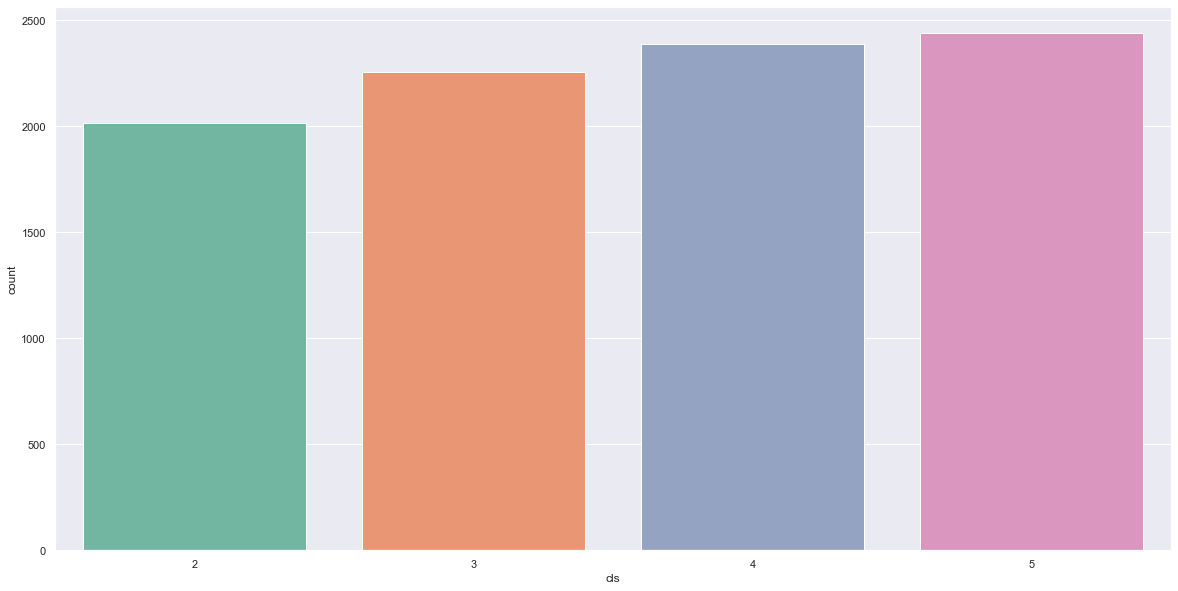

In [27]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='cls', data=df_gen, palette="Set2")

Т.к. сгенерированны данные только для тренировочной выборки, то тестовую выборку получим из начальных данных

In [28]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df.drop(['num_misspelled_tokens', 'num_shell_noun', 'name', 'type', 'punct_mistakes_pp', 'punct_mistakes_because', 'punct_mistakes_but', 'punct_mistakes_compare', 'side_mistake'],  inplace=True, axis=1)
df['class'] = round(df['class'] / 10).astype(int)
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

df = df.rename(columns = {'class': 'cls'})
feature_columns = [col for col in df.columns if col not in ['cls',]]
X = df[feature_columns]
y = df['cls']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [31]:
feature_columns = [col for col in df_gen.columns if col not in ['cls',]]
train_x = df_gen[feature_columns]
train_y = df_gen['cls']